<a href="https://colab.research.google.com/github/SimoSnoussi/UpwellNet-/blob/master/Upwell-Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm 

from keras import backend as K 
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, Dropout, Reshape, Conv2DTranspose, Add
from keras.layers import BatchNormalization, Activation 
from keras.models import Model, load_model 
from keras.optimizers import Adam 
from IPython.display import SVG 
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau 
from keras.utils import np_utils, plot_model

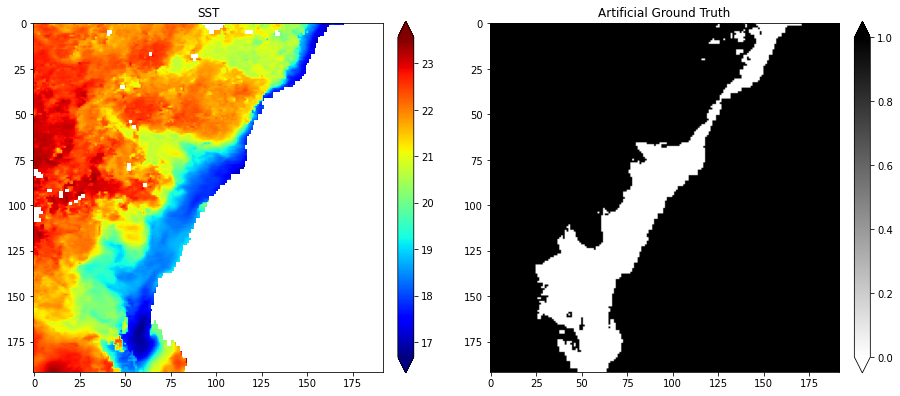

In [17]:
sst_path  = '/content/drive/My Drive/Article_2/Train_data/SST_train.npy'
mask_path = '/content/drive/My Drive/Article_2/Train_data/MASK_train.npy'

sst_train  = np.load(sst_path)
mask_train = np.load(mask_path)

mask_train = np.nan_to_num(mask_train, nan=1)
index = np.random.randint(sst_train.shape[0])

plt.figure(figsize=(15, 10))

plt.subplot(121)
plt.imshow(sst_train[index,:,:], cmap='jet')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
plt.title('SST');

plt.subplot(122)
plt.imshow(mask_train[index,:,:], cmap='binary')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
plt.title('Artificial Ground Truth');

In [0]:
sst_train = np.nan_to_num(sst_train, nan=1)

### Expand dims 
sst_train = np.expand_dims(sst_train, 3)
mask_train = np.expand_dims(mask_train, 3)

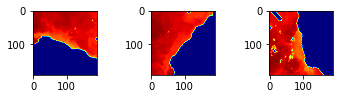

In [0]:
### Data Augumentation (Optional)
from keras.preprocessing.image import ImageDataGenerator 
datagen = ImageDataGenerator(rotation_range=90)
datagen.fit(sst_train)

for X_batch, y_batch in datagen.flow(sst_train, mask_train, batch_size=9):
	# create a grid of 3x3 images
	for i in range(0, 3):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(192, 192), cmap='jet')
		np.save('/content/drive/My Drive/Article_2/Train_data/Data_Agum/'+'aug_{}.npy'.format(i), X_batch[i].reshape(192, 192))
	# show the plot
	plt.show()
	break

In [19]:
### One-Hot-Encoding 
mask_train_cat = np.reshape(mask_train[:,:,:,0], (1374,192*192))
mask_train_cat = np_utils.to_categorical(mask_train_cat, 2)
print(mask_train_cat.shape)

(1374, 36864, 2)


In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [0]:
input_size  = (192, 192, 1) 
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True, num_classes=2):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    # Bottleneck 
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    output     = Conv2D(num_classes, (1,1), padding='valid')(c9)
    output     = Reshape((input_size[0]*input_size[1], num_classes))(output)
    output     = Activation('softmax')(output)
    model = Model(inputs=[input_img], outputs=[output])
    return model

# Calculate Weigths (Data Imbalance)

In [22]:
unique, counts = np.unique(mask_train, return_counts=True)
dict(zip(unique, counts))

{0.0: 8085897, 1.0: 42565239}

In [23]:
freq = [np.sum(counts)/j for j in counts]
weightsSeg = [f/np.sum(freq) for f in freq]
weightsSeg

[0.8403609940752366, 0.15963900592476346]

In [0]:
epsilon=0.00001  ## small constant add to numerator and denominator to avoid division by zero errors. 

### IoU coefficient 
def iou_class_1(y_true, y_pred):
  y_true_ = y_true[:,:,0]
  y_pred_ = y_pred[:,:,0]
  intersection = K.sum(y_true_ * y_pred_)
  union = (K.sum(y_true_) + K.sum(y_pred_)) - intersection
  iou = (intersection + epsilon) / (union + epsilon)
  return iou

def iou_class_2(y_true, y_pred):
  y_true_ = y_true[:,:,1]
  y_pred_ = y_pred[:,:,1]
  intersection = K.sum(y_true_ * y_pred_)
  union = (K.sum(y_true_) + K.sum(y_pred_)) - intersection
  iou = (intersection + epsilon) / (union + epsilon)
  return iou

def mean_iou(y_true, y_pred): 
  return ((iou_class_1(y_true, y_pred) + iou_class_2(y_true, y_pred)) / 2)


### Dice Coefficient 
def dice_coef_class_1(y_true, y_pred): 
  y_true_ = y_true[:,:,0]
  y_pred_ = y_pred[:,:,0]
  dice_numerator   = 2 * K.sum(y_true_ * y_pred_) + epsilon 
  dice_denominator = K.sum(y_true_) + K.sum(y_pred_) + epsilon 
  dice_coeff       = dice_numerator / dice_denominator 
  return dice_coeff 

def dice_coef_class_2(y_true, y_pred): 
  y_true_ = y_true[:,:,1]
  y_pred_ = y_pred[:,:,1]
  dice_numerator   = 2 * K.sum(y_true_ * y_pred_) + epsilon 
  dice_denominator = K.sum(y_true_) + K.sum(y_pred_) + epsilon 
  dice_coeff       = dice_numerator / dice_denominator
  return dice_coeff 

def dice_coefficient(y_true, y_pred): 
  return ((dice_coef_class_1(y_true, y_pred) + dice_coef_class_2(y_true, y_pred)) / 2) 

### Weighted Dice Loss 
def weighted_dice_coef(y_true, y_pred):
    return (0.84*dice_coef_class_1(y_true, y_pred) + 0.16*dice_coef_class_2(y_true, y_pred))
  
def dice_coef_loss(y_true, y_pred):
    return 1 - weighted_dice_coef(y_true, y_pred)

In [25]:
input_img = Input(input_size)
model = get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True)

model.compile(optimizer=Adam(), loss=dice_coef_loss, metrics=["categorical_accuracy", dice_coefficient, 
                                                              dice_coef_class_1, dice_coef_class_2, mean_iou])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 192, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 192, 192, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 192, 192, 16) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

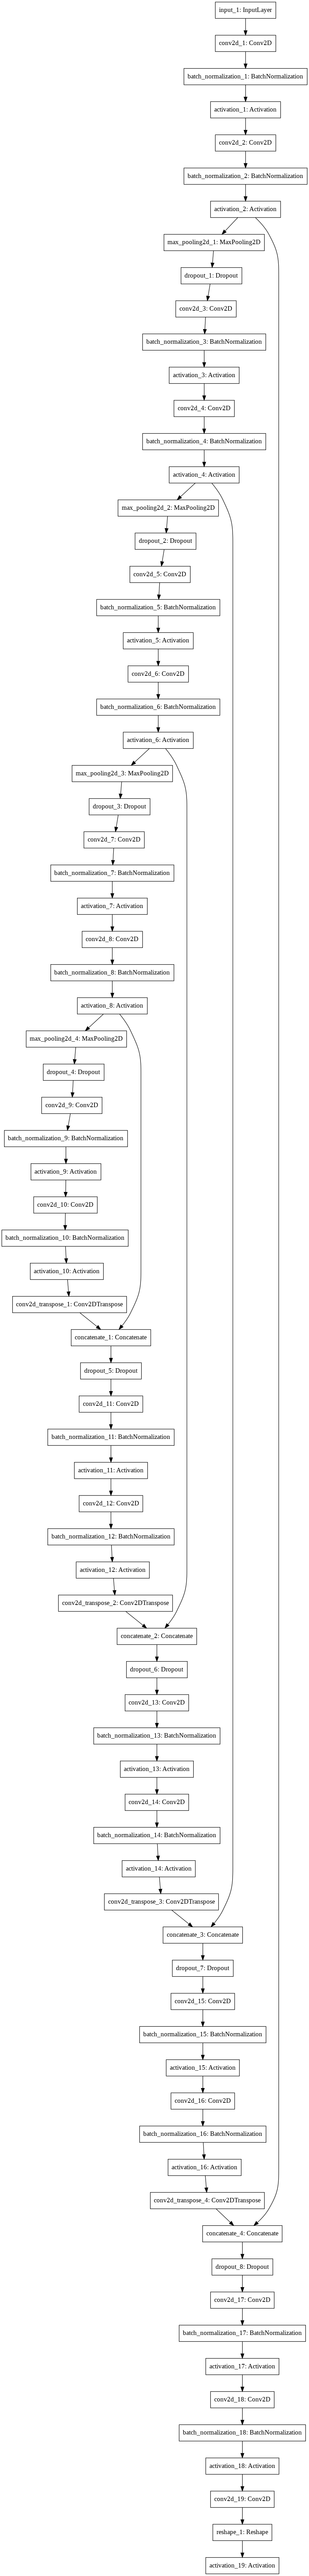

In [26]:
from keras.utils import plot_model 
plot_model(model)

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.0001, verbose=1),
    ModelCheckpoint('/content/drive/My Drive/Article_2/weigths/model-UupwellNet-0.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [0]:
results = model.fit(sst_train, mask_train_cat, 
                    batch_size=16, 
                    epochs=50,
                    shuffle=True,
                    verbose=1,  
                    callbacks=callbacks, 
                    validation_split=0.2)

Train on 1099 samples, validate on 275 samples
Epoch 1/50
1099/1099 [==============================] - 32s 29ms/step - loss: 0.4301 - categorical_accuracy: 0.8139 - dice_coefficient: 0.6646 - dice_coef_class_1: 0.5262 - dice_coef_class_2: 0.8030 - mean_iou: 0.5229 - val_loss: 0.5170 - val_categorical_accuracy: 0.6283 - val_dice_coefficient: 0.5700 - val_dice_coef_class_1: 0.4428 - val_dice_coef_class_2: 0.6972 - val_mean_iou: 0.4102

Epoch 00001: val_loss improved from inf to 0.51696, saving model to /content/drive/My Drive/Article_2/weigths/model-UupwellNet-0.h5
Epoch 2/50
1099/1099 [==============================] - 20s 18ms/step - loss: 0.2521 - categorical_accuracy: 0.9305 - dice_coefficient: 0.8221 - dice_coef_class_1: 0.7133 - dice_coef_class_2: 0.9308 - mean_iou: 0.7134 - val_loss: 0.6851 - val_categorical_accuracy: 0.3175 - val_dice_coefficient: 0.3142 - val_dice_coef_class_1: 0.3160 - val_dice_coef_class_2: 0.3123 - val_mean_iou: 0.1866

Epoch 00002: val_loss did not improve f

In [0]:
model.load_weights('/content/drive/My Drive/Article_2/weigths/model-UupwellNet-0.h5')

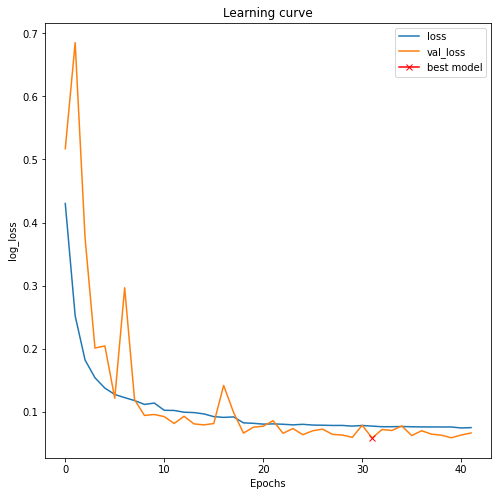

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

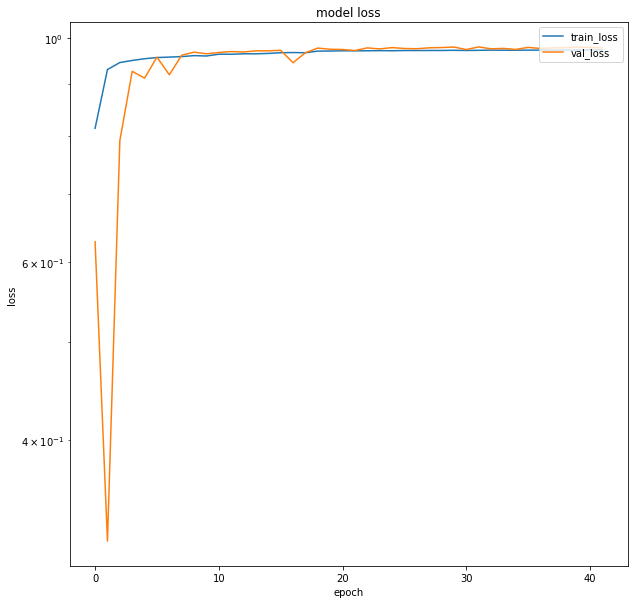

In [0]:
plt.figure(figsize=(10, 10))
plt.semilogy(model.history.history['categorical_accuracy'])
plt.semilogy(model.history.history['val_categorical_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right');

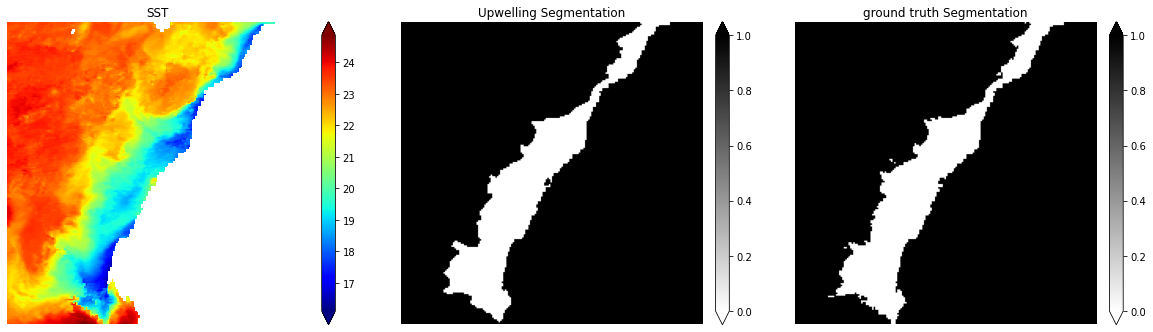

In [0]:
randindex=np.random.randint(0,len(sst_train))
predictedSEGM=model.predict(np.reshape(sst_train[randindex,:,:],(1,input_size[0],input_size[1],1)))
predictedSEGMimage = np.reshape(predictedSEGM.argmax(2),(input_size[0],input_size[1]))

plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(np.where(sst_train[randindex,:,:,0]==1, np.nan, sst_train[randindex,:,:,0]), cmap='jet')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('SST');

plt.subplot(132)
plt.imshow(predictedSEGMimage, cmap='binary')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('Upwelling Segmentation');

plt.subplot(133)
plt.imshow(mask_train[randindex,:,:,0], cmap='binary')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
#plt.clim(-0.25,0.25)
plt.axis('off')
plt.title('ground truth Segmentation');

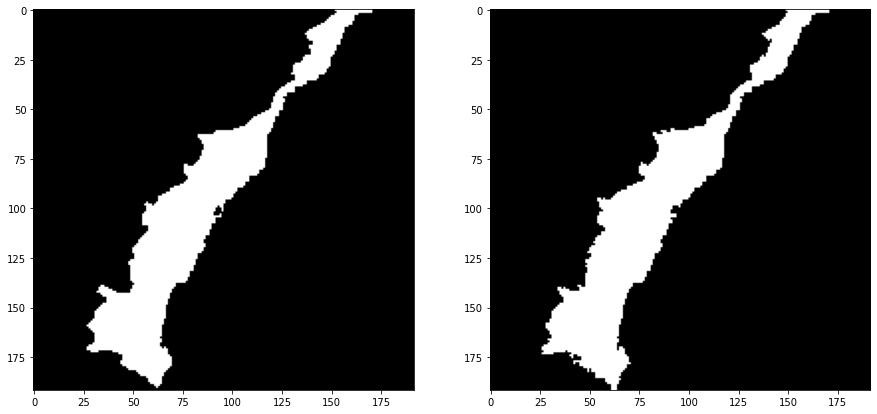

In [0]:
from skimage import morphology 
from scipy import ndimage 

### Like region growing to remove offshore noise 
def like_region_growing(label): 
    a = label > 0 
    b = morphology.remove_small_holes(a)
    c = b.astype(int)
    c = np.where(c==0,1, 0)
    d = ndimage.binary_fill_holes(c)
    e = np.where(d==1, 0, 1)
    return e 

label = like_region_growing(predictedSEGMimage)
label2 = like_region_growing(mask_train[randindex,:,:,0])

fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(15,10))
ax0.imshow(label, cmap='binary')
ax1.imshow(label2, cmap='binary')  